In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


plt.rcParams["figure.figsize"] = (10,5)

In [2]:
pd.options.display.max_columns = 1000

In [3]:
test = pd.read_csv("/data/covid19/test.csv")
train = pd.read_csv("/data/covid19/train.csv")

In [4]:
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-26
1,2,NaN,Afghanistan,2020-03-27
2,3,NaN,Afghanistan,2020-03-28
3,4,NaN,Afghanistan,2020-03-29
4,5,NaN,Afghanistan,2020-03-30


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22338 entries, 0 to 22337
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              22338 non-null  int64  
 1   Province_State  9490 non-null   object 
 2   Country_Region  22338 non-null  object 
 3   Date            22338 non-null  object 
 4   ConfirmedCases  22338 non-null  float64
 5   Fatalities      22338 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ MB


In [7]:
train.drop(columns="Id").describe()

,ConfirmedCases,Fatalities
count,22338.000000,22338.000000
mean,610.647372,26.520906
std,5150.283215,354.743581
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,45.000000,0.000000
max,119827.000000,14681.000000


In [8]:
train.Country_Region.nunique()

180

In [9]:
min(train.Date), max(train.Date), train.Date.nunique()

('2020-01-22', '2020-04-03', 73)

In [10]:
#train.Date = pd.to_datetime(train.Date)

In [11]:
train[~train.Province_State.isna()].Country_Region.unique()

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Netherlands',
       'US', 'United Kingdom'], dtype=object)

In [12]:
train[train.Country_Region=="Italy"].ConfirmedCases

10585         0.0
10586         0.0
10587         0.0
10588         0.0
10589         0.0
           ...   
10653    101739.0
10654    105792.0
10655    110574.0
10656    115242.0
10657    119827.0
Name: ConfirmedCases, Length: 73, dtype: float64

Text(0.5, 1.0, 'Fatalities')

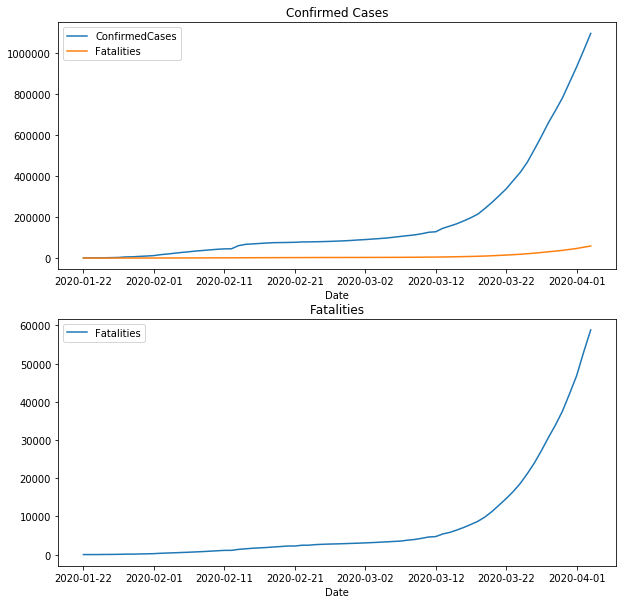

In [13]:
fig, axes = plt.subplots(2, 1, figsize = (10, 10))
train.groupby("Date").agg({"ConfirmedCases": "sum","Fatalities": "sum"}).plot(ax = fig.axes[0])
train.groupby("Date").agg({"Fatalities": "sum"}).plot(ax = fig.axes[1])
fig.axes[0].set_title("Confirmed Cases")
fig.axes[1].set_title("Fatalities")

Text(0.5, 1.0, 'Fatalities (Excluding China)')

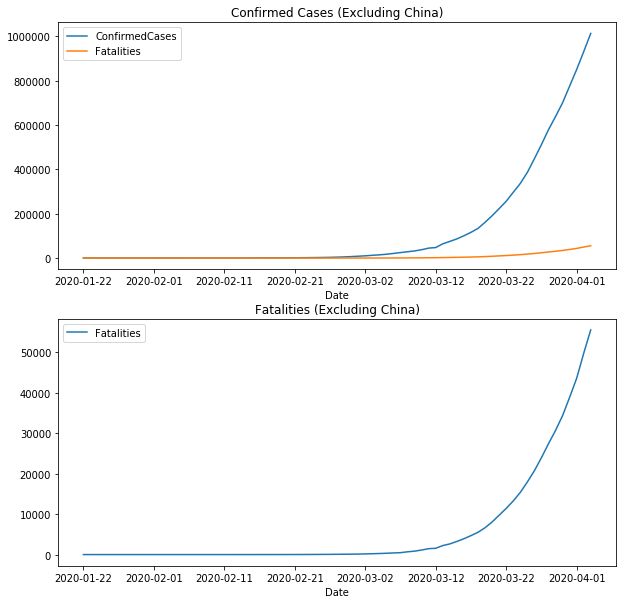

In [14]:
fig, axes = plt.subplots(2, 1, figsize = (10, 10))
train[train.Country_Region != "China"].groupby("Date").agg({"ConfirmedCases": "sum","Fatalities": "sum"}).plot(ax = fig.axes[0])
train[train.Country_Region != "China"].groupby("Date").agg({"Fatalities": "sum"}).plot(ax = fig.axes[1])
fig.axes[0].set_title("Confirmed Cases (Excluding China)")
fig.axes[1].set_title("Fatalities (Excluding China)")

Text(0.5, 1.0, 'Fatalities (In China)')

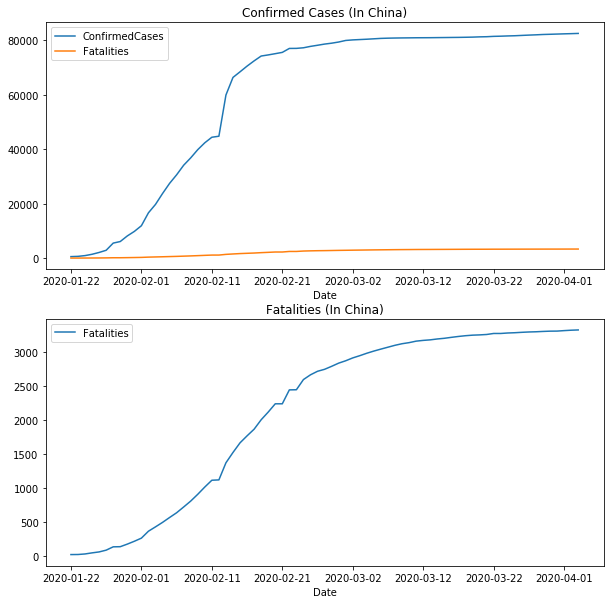

In [15]:
fig, axes = plt.subplots(2, 1, figsize = (10, 10))
train[train.Country_Region == "China"].groupby("Date").agg({"ConfirmedCases": "sum","Fatalities": "sum"}).plot(ax = fig.axes[0])
train[train.Country_Region == "China"].groupby("Date").agg({"Fatalities": "sum"}).plot(ax = fig.axes[1])
fig.axes[0].set_title("Confirmed Cases (In China)")
fig.axes[1].set_title("Fatalities (In China)")

In [16]:
countries = ["Italy", "Spain", "United Kingdom", "Singapore"]

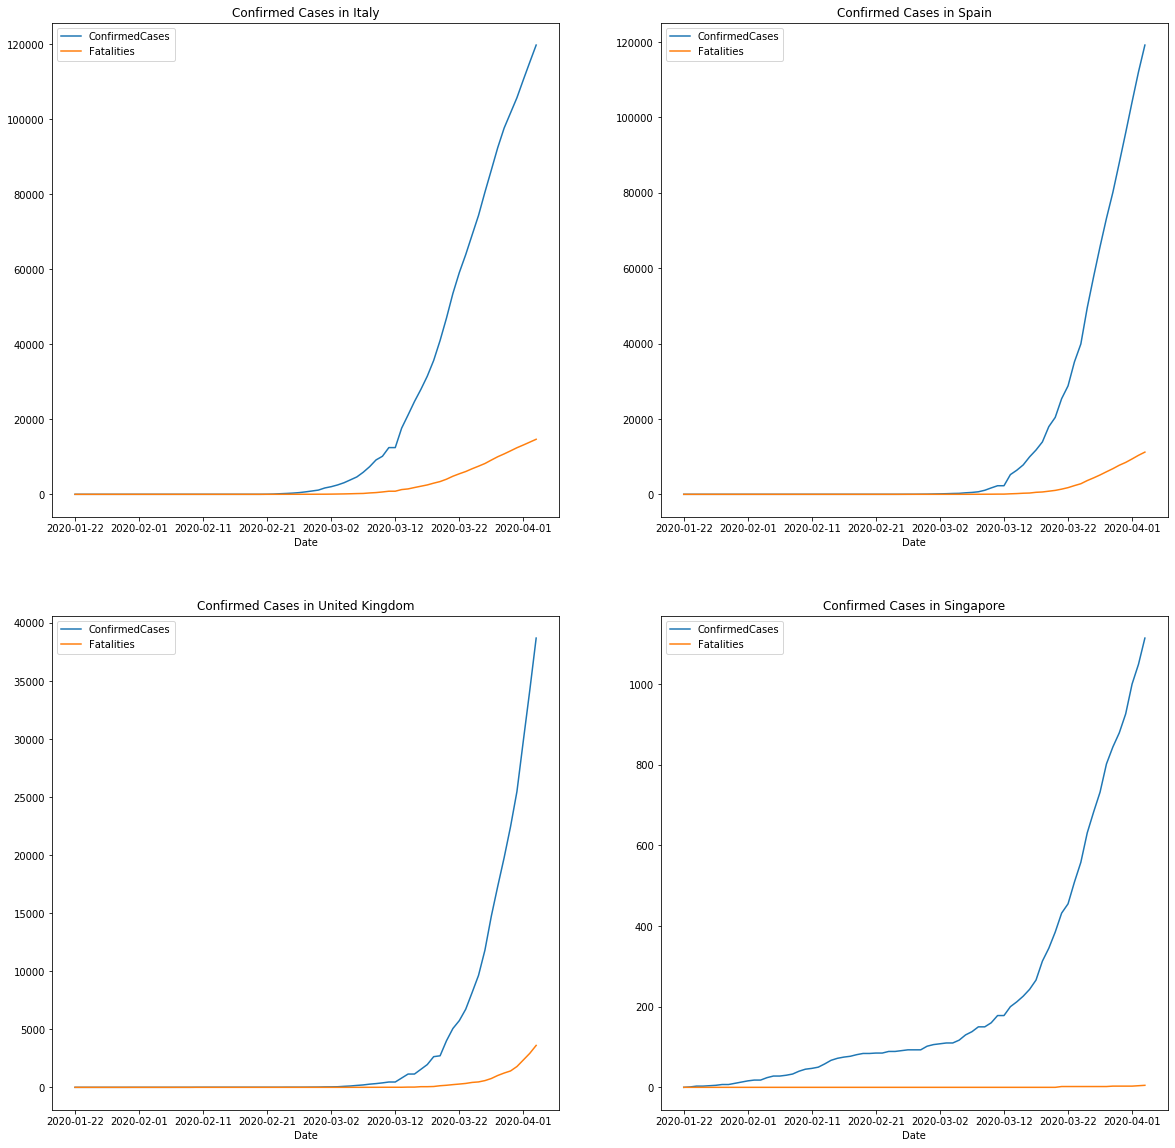

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (20, 20))

for i, country in enumerate(countries):
    (train[train.Country_Region == country]
        .groupby("Date").agg({"ConfirmedCases": "sum","Fatalities": "sum"})
        .plot(ax = fig.axes[i]))
    fig.axes[i].set_title("Confirmed Cases in " + country)

In [18]:
dfs = []
for i, country in enumerate(countries):
    df = train[(train.Country_Region == country) 
                   & (train.ConfirmedCases>0)].groupby("Date").ConfirmedCases.agg(["sum"])
    df.index = pd.to_datetime(df.index)
    df["days"] = df.index - df.index[0]
    df["days"] = df["days"].apply(lambda r: r.days)
    df = df.reset_index()[["sum", "days"]]
    df.columns = [country, "days"]
    df.index = df.days
    
    del df["days"]
    dfs.append(df)
    
df = dfs[0]
for d in dfs[1:]:
    df = df.merge(d, left_index = True, right_index = True)

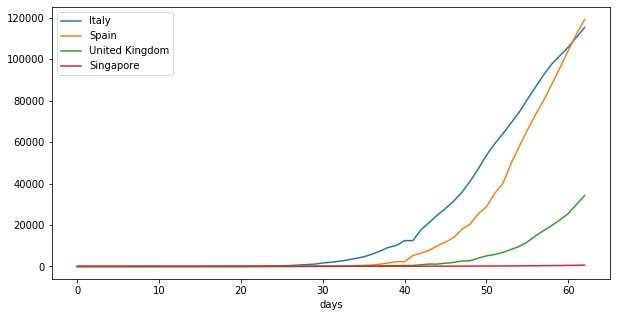

In [19]:
df.plot(logy = False)

In [20]:
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [21]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [22]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

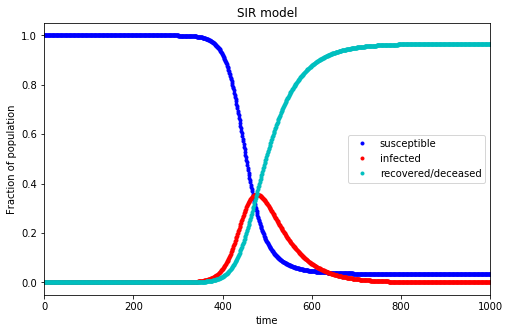

In [23]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

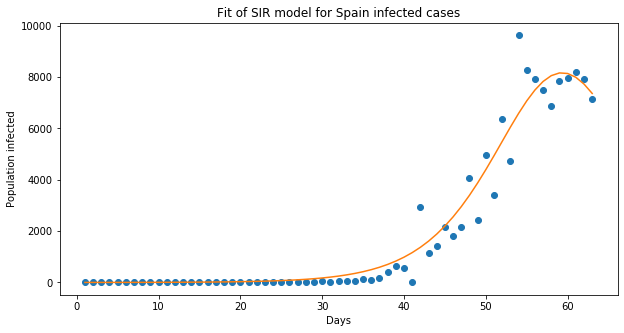

Optimal parameters: beta = 9.569017512881123  and gamma =  9.390663146590638


In [24]:
population = float(46750238)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [25]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-26', 'ConfirmedCases'] = 0
all_data.loc[all_data['Date'] >= '2020-03-26', 'Fatalities'] = 0
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

all_data.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020


In [26]:
all_data.loc[all_data['Date'] == '2020-03-26'].head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,-1.0,None,Afghanistan,2020-03-26,0.0,0.0,1.0,64,26,3,2020
43,-1.0,None,Albania,2020-03-26,0.0,0.0,44.0,64,26,3,2020
86,-1.0,None,Algeria,2020-03-26,0.0,0.0,87.0,64,26,3,2020
129,-1.0,None,Andorra,2020-03-26,0.0,0.0,130.0,64,26,3,2020
172,-1.0,None,Angola,2020-03-26,0.0,0.0,173.0,64,26,3,2020


In [27]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


In [28]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0)
    return df

def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df.groupby(['Country_Region', 'Province_State'])[column].shift(0, fill_value=0) - 
                                df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0))/df.groupby(['Country_Region', 'Province_State'])[column].shift(lag, fill_value=0.001)
    return df


ts = time.time()
all_data = calculate_lag(all_data.reset_index(), range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  2.672288179397583


In [29]:
all_data.head()

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
13928,23260.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
13929,23261.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
13930,23262.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
13931,23263.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
13932,23264.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
13933,23265.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
13934,23266.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
13935,23267.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
13936,23268.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
13937,23269.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


In [31]:
world_population = pd.read_csv("/data/covid19/population_by_country_2020.csv")
world_population.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [32]:
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']
world_population.head()

,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61%
1,India,1380004385,464,2973190,28,35%
2,United States,331002651,36,9147420,38,83%
3,Indonesia,273523615,151,1811570,30,56%
4,Pakistan,220892340,287,770880,23,35%


In [33]:
# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'
world_population.head()

,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61%
1,India,1380004385,464,2973190,28,35%
2,US,331002651,36,9147420,38,83%
3,Indonesia,273523615,151,1811570,30,56%
4,Pakistan,220892340,287,770880,23,35%


In [34]:
# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')
world_population.head()

,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35


In [35]:
# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
world_population.head()

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35


In [36]:
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
all_data.head()

Joined dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
1,1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
2,2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
3,3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
4,4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0


In [37]:
print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 

all_data.head()


Encoded dataset


,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,0,1.0,81,0,2020-01-22,0.0,0.0,-1.0,0,22,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
1,1,2.0,81,0,2020-01-23,0.0,0.0,-1.0,1,23,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
2,2,3.0,81,0,2020-01-24,0.0,0.0,-1.0,2,24,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
3,3,4.0,81,0,2020-01-25,0.0,0.0,-1.0,3,25,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
4,4,5.0,81,0,2020-01-26,0.0,0.0,-1.0,4,26,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0


Text(0, 0.5, 'Log ConfirmedCases')

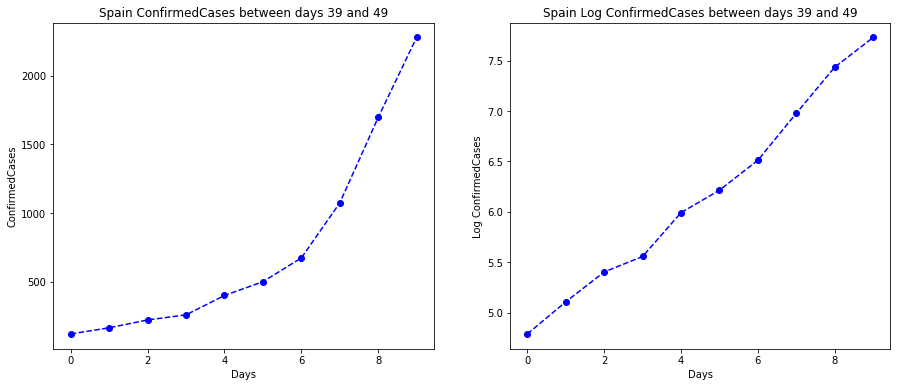

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

In [39]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(df, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    # Train set
    x_train = df[df.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = df[df.ForecastId == -1]['ConfirmedCases']
    y_train_2 = df[df.ForecastId == -1]['Fatalities']

    # Test set
    x_test = df[df.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    return submission

In [40]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03']

In [41]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][50:70]

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Trend_ConfirmedCases_1,Trend_ConfirmedCases_2,Trend_ConfirmedCases_3,Trend_ConfirmedCases_4,Trend_ConfirmedCases_5,Trend_ConfirmedCases_6,Trend_Fatalities_1,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
13938,15891,23270.0,81,153,2020-03-12,2277.0,55.0,-1.0,50,12,3,2020,2277.0,1695.0,1073.0,673.0,500.0,400.0,54.0,35.0,28.0,17.0,10.0,5.0,0.000000,0.343363,1.122088,2.383358,3.554000,4.692500,0.018519,0.571429,0.964286,2.235294,4.500000,10.000000,46754778.0,94.0,498800.0,45.0,80.0
13939,15892,23271.0,81,153,2020-03-13,5232.0,133.0,-1.0,51,13,3,2020,2277.0,2277.0,1695.0,1073.0,673.0,500.0,55.0,54.0,35.0,28.0,17.0,10.0,1.297760,1.297760,2.086726,3.876048,6.774146,9.464000,1.418182,1.462963,2.800000,3.750000,6.823529,12.300000,46754778.0,94.0,498800.0,45.0,80.0
13940,15893,23272.0,81,153,2020-03-14,6391.0,195.0,-1.0,52,14,3,2020,5232.0,2277.0,2277.0,1695.0,1073.0,673.0,133.0,55.0,54.0,35.0,28.0,17.0,0.221521,1.806763,1.806763,2.770501,4.956198,8.496285,0.466165,2.545455,2.611111,4.571429,5.964286,10.470588,46754778.0,94.0,498800.0,45.0,80.0
13941,15894,23273.0,81,153,2020-03-15,7798.0,289.0,-1.0,53,15,3,2020,6391.0,5232.0,2277.0,2277.0,1695.0,1073.0,195.0,133.0,55.0,54.0,35.0,28.0,0.220153,0.490443,2.424682,2.424682,3.600590,6.267474,0.482051,1.172932,4.254545,4.351852,7.257143,9.321429,46754778.0,94.0,498800.0,45.0,80.0
13942,15895,23274.0,81,153,2020-03-16,9942.0,342.0,-1.0,54,16,3,2020,7798.0,6391.0,5232.0,2277.0,2277.0,1695.0,289.0,195.0,133.0,55.0,54.0,35.0,0.274942,0.555625,0.900229,3.366271,3.366271,4.865487,0.183391,0.753846,1.571429,5.218182,5.333333,8.771429,46754778.0,94.0,498800.0,45.0,80.0
13943,15896,23275.0,81,153,2020-03-17,11748.0,533.0,-1.0,55,17,3,2020,9942.0,7798.0,6391.0,5232.0,2277.0,2277.0,342.0,289.0,195.0,133.0,55.0,54.0,0.181654,0.506540,0.838210,1.245413,4.159420,4.159420,0.558480,0.844291,1.733333,3.007519,8.690909,8.870370,46754778.0,94.0,498800.0,45.0,80.0
13944,15897,23276.0,81,153,2020-03-18,13910.0,623.0,-1.0,56,18,3,2020,11748.0,9942.0,7798.0,6391.0,5232.0,2277.0,533.0,342.0,289.0,195.0,133.0,55.0,0.184031,0.399115,0.783791,1.176498,1.658639,5.108915,0.168856,0.821637,1.155709,2.194872,3.684211,10.327273,46754778.0,94.0,498800.0,45.0,80.0
13945,15898,23277.0,81,153,2020-03-19,17963.0,830.0,-1.0,57,19,3,2020,13910.0,11748.0,9942.0,7798.0,6391.0,5232.0,623.0,533.0,342.0,289.0,195.0,133.0,0.291373,0.529026,0.806779,1.303539,1.810671,2.433295,0.332263,0.557223,1.426901,1.871972,3.256410,5.240602,46754778.0,94.0,498800.0,45.0,80.0
13946,15899,23278.0,81,153,2020-03-20,20410.0,1043.0,-1.0,58,20,3,2020,17963.0,13910.0,11748.0,9942.0,7798.0,6391.0,830.0,623.0,533.0,342.0,289.0,195.0,0.136224,0.467290,0.737317,1.052907,1.617338,2.193553,0.256627,0.674157,0.956848,2.049708,2.608997,4.348718,46754778.0,94.0,498800.0,45.0,80.0
13947,15900,23279.0,81,153,2020-03-21,25374.0,1375.0,-1.0,59,21,3,2020,20410.0,17963.0,13910.0,11748.0,9942.0,7798.0,1043.0,830.0,623.0,533.0,342.0,289.0,0.243214,0.412570,0.824155,1.159857,1.552203,2.253911,0.318313,0.656627,1.207063,1.579737,3.020468,3.757785,46754778.0,94.0,498800.0,45.0,80.0


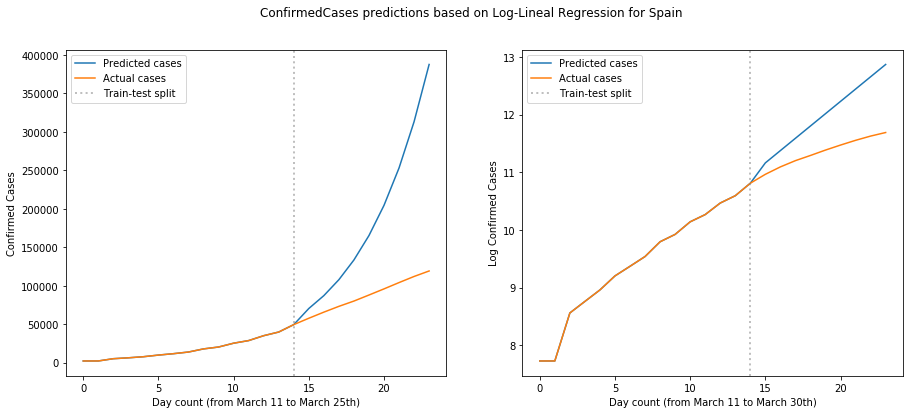

In [42]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift, train_lim, test_lim):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country, train_lim, test_lim)
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    X_final_check = pd.concat([X_train_check, X_test_check])

    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(24-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(24-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
    
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
train_lim, test_lim = 63, 106
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

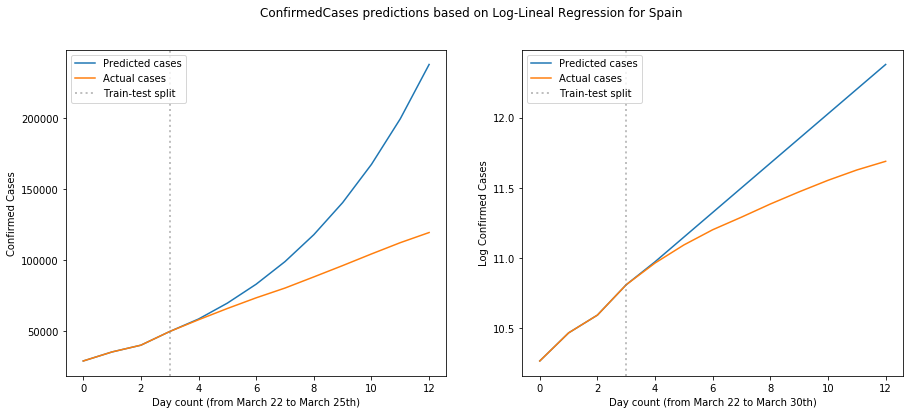

In [43]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

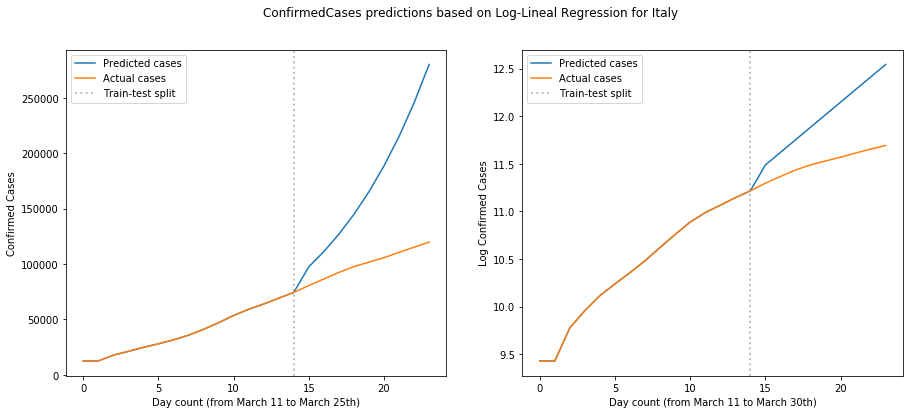

In [44]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

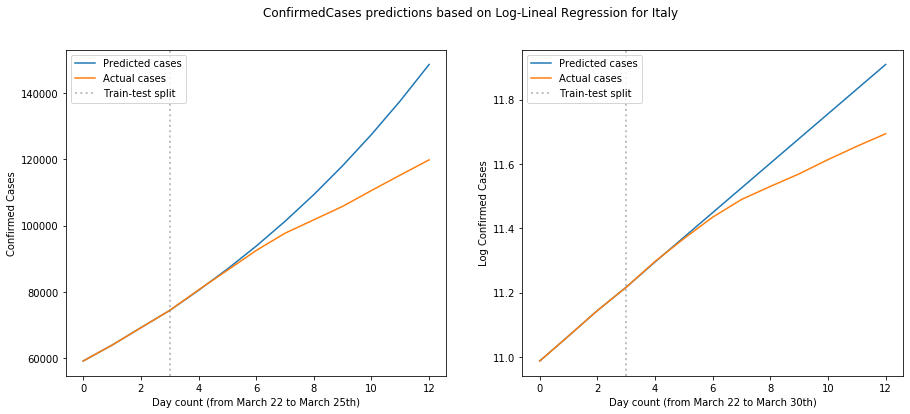

In [45]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

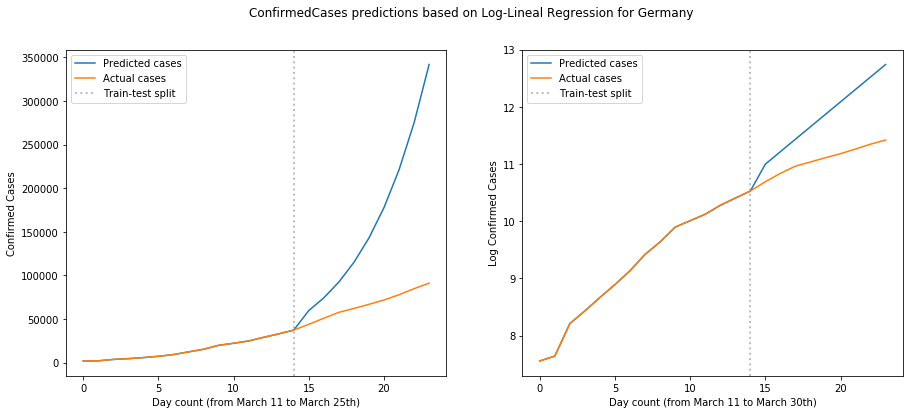

In [46]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)


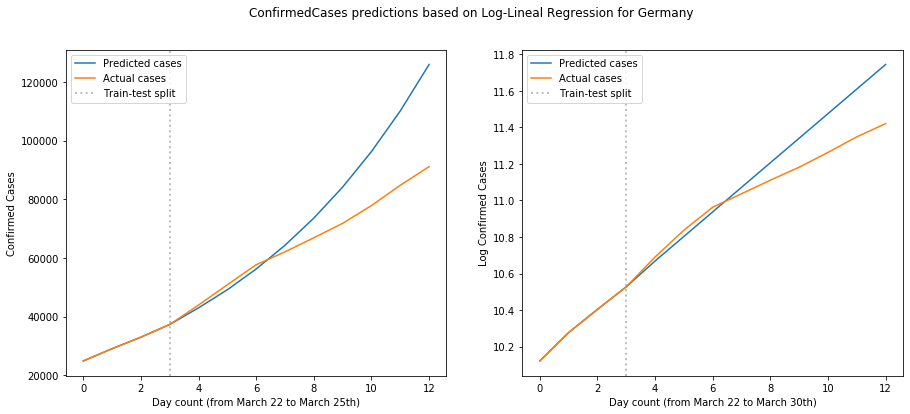

In [47]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

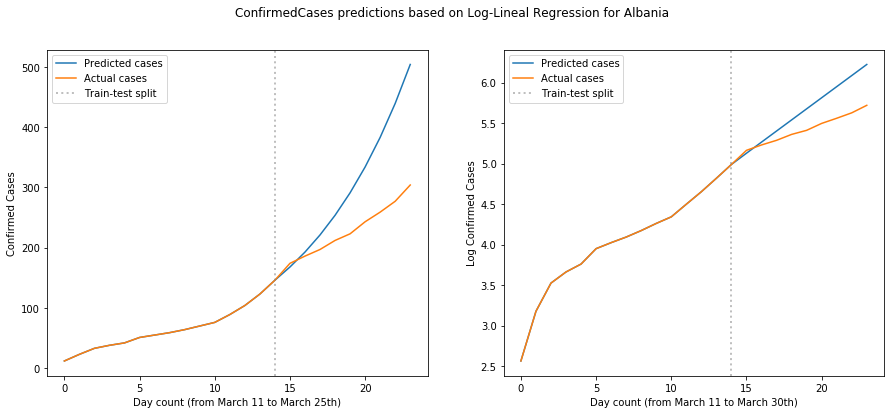

In [48]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 10
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

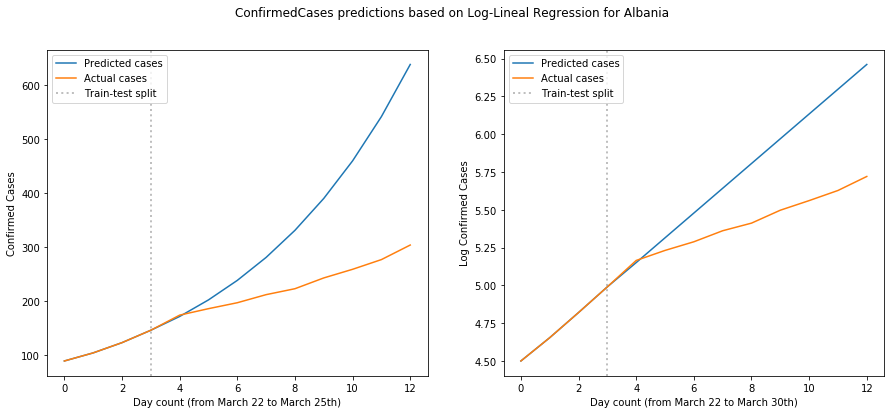

In [49]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 21
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day, train_lim, test_lim)

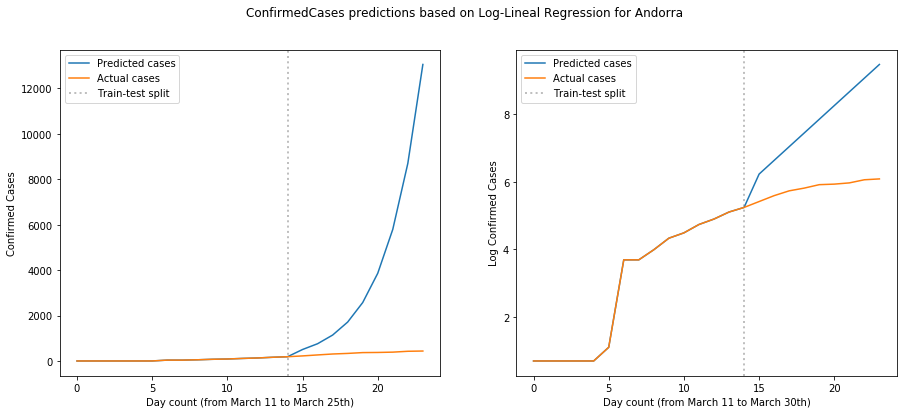

In [50]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 10
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

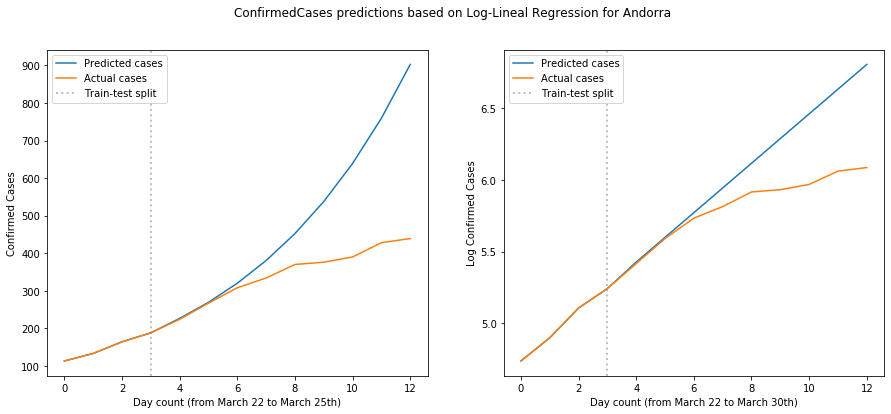

In [51]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 21
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift, train_lim, test_lim)

Observations:

The general evolution is captured despite the simplicity of the model
The cumulative infected cases has been changing in March, so that using thw whole month data for training results in overestimated predictions. When reducing the training set to only a few days prior the testing region, results are better. This is capturing the problem of the exponential behavior, that is only true for the early stages of the spreading. Now the behavior is more complex, and in order to predict the evolution with large portions of the historic evolution, alternative models are required (sigmoid, ARIMA...)
Estimations are increasingly worse as time passes (harder to extrapolate)
Countries that recently confirmed their first contagions are difficult to predict (less data points)
Countries with 0 cases in the whole training dataset are predicted as non-infected (no datapoints)
Questions to tackle in next subsections:

How to obtain the full submission set?
What to do for countries with different Provinces/State informed?
Is there any alternative to manually setting the size of the train data?


# Linear Regression for all countries (method 1) 
We've recently discovered that when fitting only with 10 historical datapoints some problematic scenarios appear, that impact the performance of our Linear Regressor. Let's generalize the model for all countries to verify if it's an unavoidable problem. Steps to run for all countries:

Loop for each country
Compute provinces list
If there are provinces, run the Linear Regressor for each of them
Otherwise just run the Linear Regressor

In [52]:
ts = time.time()

def linreg_basic_all_countries(data, day_start, train_lim, test_lim):
    
    data2 = data.loc[data.Day_num >= day_start]

    # Set the dataframe where we will update the predictions
    data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    print("Currently running Linear Regression for all countries")

    # Main loop for countries
    for c in data2['Country_Region'].unique():

        # List of provinces
        provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()

        # If the country has several Province/State informed
        if len(provinces_list)>1:
            for p in provinces_list:
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

        # No Province/State informed
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

    # Apply exponential transf. and clean potential infinites due to final numerical precision
    data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
    data_pred.replace([np.inf, -np.inf], 0, inplace=True) 
    
    return data_pred


day_start = 60
data_pred = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Linear Regression for all countries
Process finished in  4.52  seconds


4.3 Linear Regression for all countries (method 2) 
An alternative method to setting the number of days for the training step is to simply keep all data for each country since the first case was confirmed. However, since there are certain countries were the initial outbreak was very smooth (i.e. in Spain there was only one confirmed case for 7 days in a row), predictions may be biased by these initial periods.

In [53]:
ts = time.time()

# Set the dataframe where we will update the predictions
data2 = data.loc[data.Day_num >= day_start]
data_pred3 = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred3['Predicted_ConfirmedCases'] = [0]*len(data_pred3)
data_pred3['Predicted_Fatalities'] = [0]*len(data_pred3)
how_many_days = test.Date.nunique()
    
print("Currently running Linear Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp, train_lim, test_lim)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c, train_lim, test_lim)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
data_pred3.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(data_pred3, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Linear Regression for all countries
Process finished in  2.3  seconds


From my experiments, this apporach is not suitable for our linear regression model. In many cases there are strong transitional periods at the beginning, which frequently biases the regression. Hence, I will not apply this method on following sections, but you are welcome to use it for any other purposes.

Final LMSE score for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01:

1.62190


4.4. Linear regression with lags 
With all the previous results in mind, I quite believe that Linear Regression is a good approach for the early stages of the COVID-19 spread. Of course, this is only true for the initial outbreak we are analysing, and there's no way our model could predict when the number of new infections is going to decrease. But for short-term prediction purposes everything is fine, and we are in disposition to try to improve the results.

Remember those lagged variables we computed some sections before? Now it's time to use them, but first there's a problem to solve. If we use our dataset to predict the next following days of contagions, for the first day all the lags will be reported (from the previous days), but what about the next days? Many of the lags will be unknown (flagged as 0), since the number of ConfirmedCases is only known for the train subset. The most simple approach to overcome this is:

Begin with the train dataset, with all cases and lags reported
Forecast only the following day, through the Linear Regression
Set the new prediction as a confirmed case
Recompute lags
Repeat from step 2 to step 4 for all remaining days
As usual, I'll start training on single countries in order to analyze the behavior of the model with these new features.

In [54]:
# New split function, for one forecast day
def split_data_one_day(df, d, train_lim, test_lim):
    
    df.loc[df['Day_num']<=train_lim , 'ForecastId'] = -1
    df = df[df['Day_num']<=test_lim]
    
    #Train
    x_train = df[df.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = df[df.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + "))")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(24-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

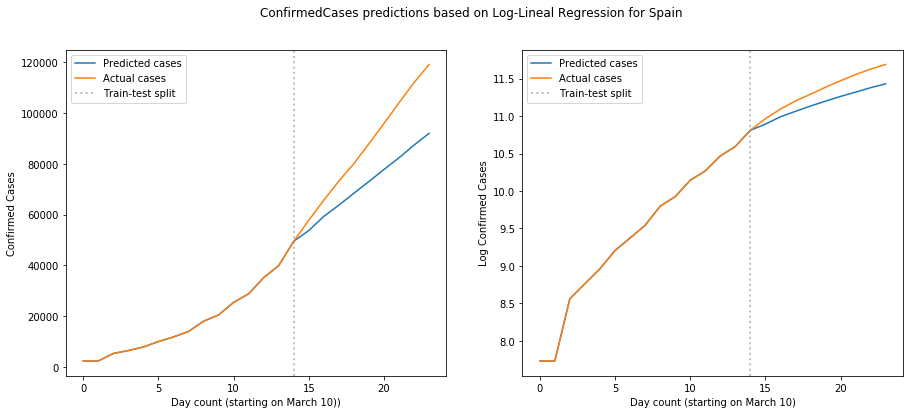

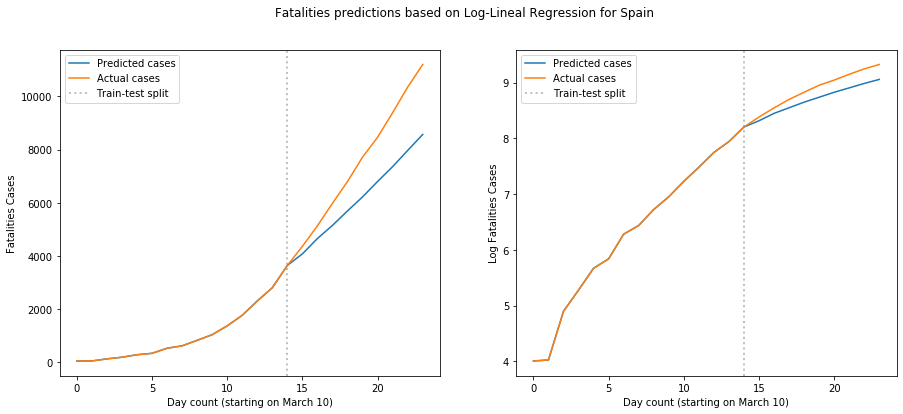

In [55]:
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d, train_lim, test_lim)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data



# Run the model for Spain
country_name = 'Spain'
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)


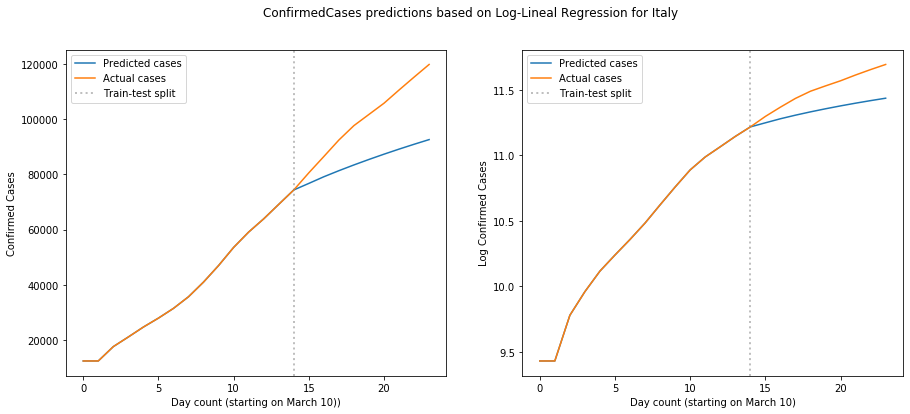

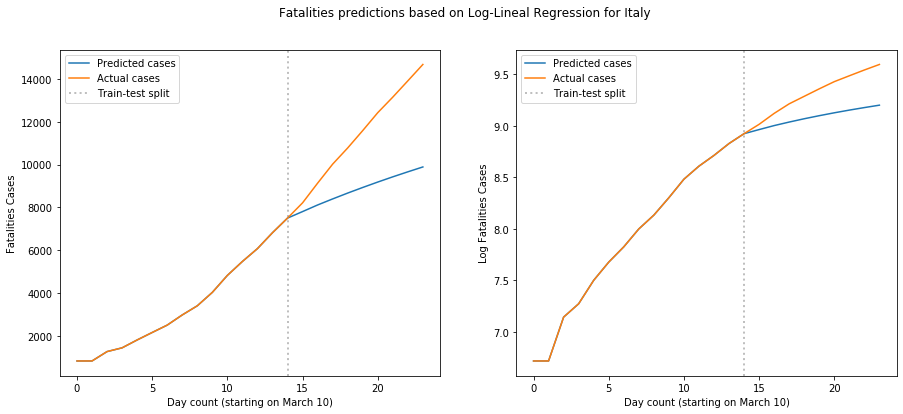

In [56]:
ts = time.time()

# Inputs
country_name = "Italy"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

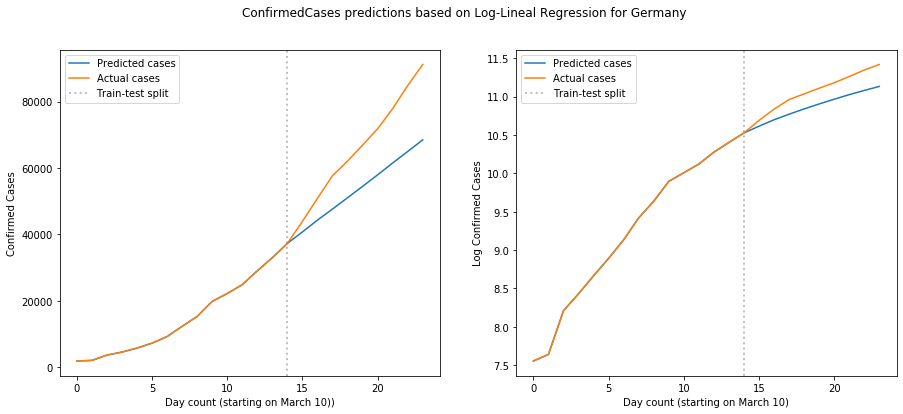

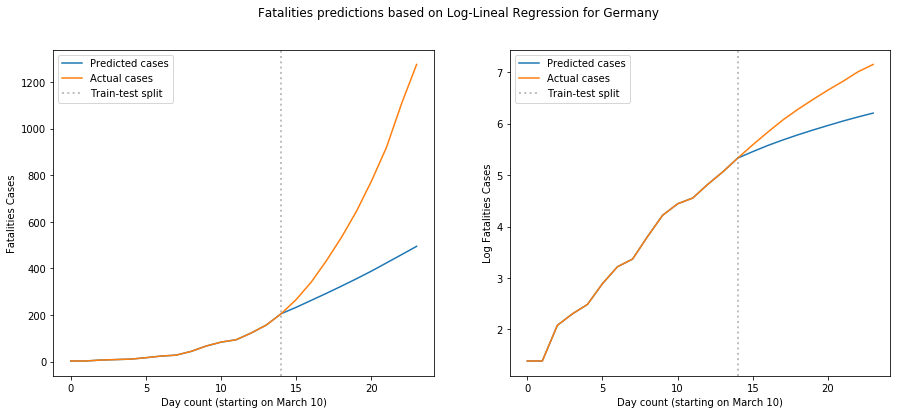

In [57]:
# Inputs
country_name = "Germany"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

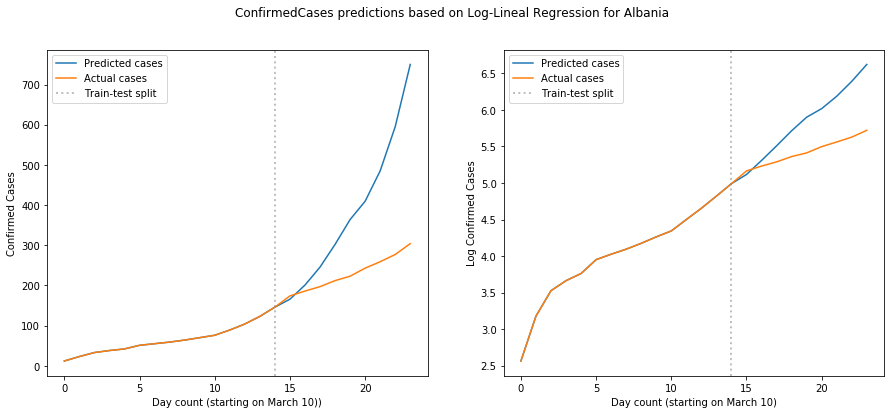

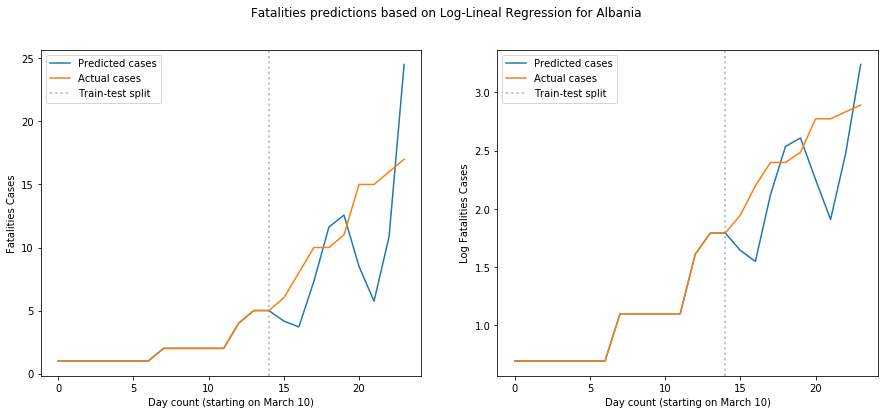

In [58]:
# Inputs
country_name = "Albania"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 7

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

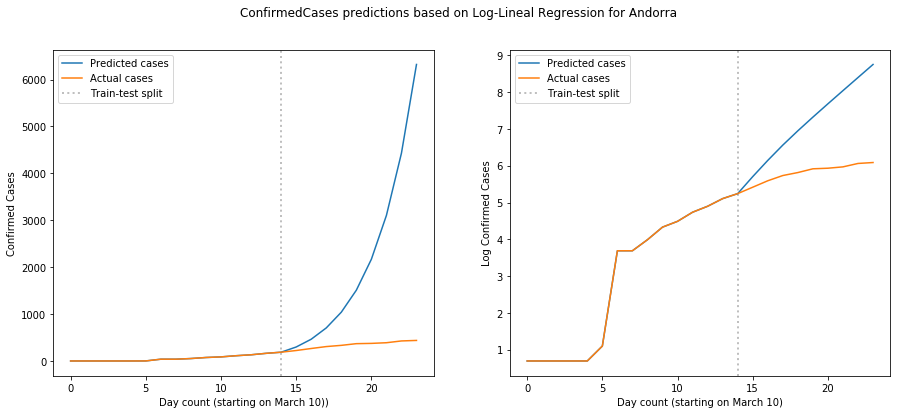

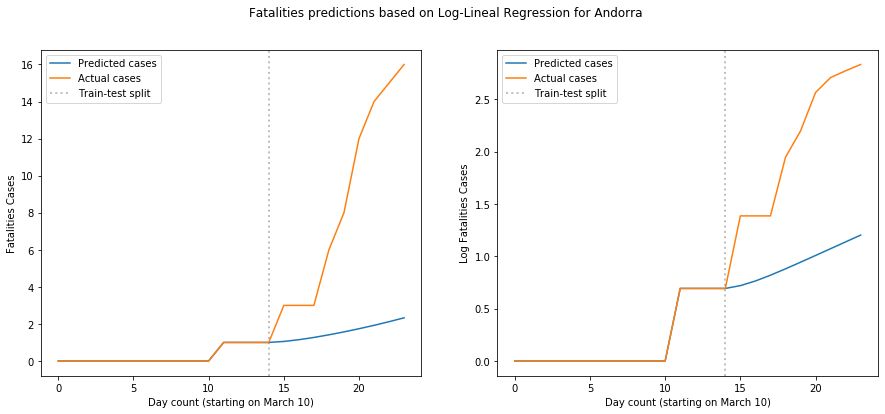

In [59]:
country_name = "Andorra"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 1

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

Observations:

Parameters. Two full weeks of training used (from February 26th to March 11th), with their previous 30 lags
Enough data. (Spain, Italy, Germany). For countries with several ConfirmedCases!=0 in the train dataset (prior to March 11th), predictions are very precise and similar to actual confirmed data
Poor data. (Algeria, Andorra). Countries with a small number of datapoints in the train dataset show a potentially disastrous prediction. Given the small number of cases, the log transformation followed by a Linear Regression is not able to capture the future behavior
No data. When the number of confirmed cases in the train dataset is 0 or negligible, the model predicts always no infections
Let's generalize the model with lags for training each country day by day:

In [60]:
day_start = 39 
lag_size = 30

train3 = train.copy()
train3.Province_State.fillna("None", inplace=True)

results_df = pd.DataFrame()

tp = time.time()

# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
            pred_province = lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict, train_lim, test_lim)
            results_df = pd.concat([results_df, pred_province])

    else:
        pred_country = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict, train_lim, test_lim)
        results_df = pd.concat([results_df, pred_country])
        
results_df_submit = results_df.copy()
results_df_submit['ConfirmedCases'] = results_df_submit['ConfirmedCases'].apply(lambda x: np.expm1(x))
results_df_submit['Fatalities'] = results_df_submit['Fatalities'].apply(lambda x: np.expm1(x))
        
#get_submission(results_df_submit.loc[results_df_submit['ForecastId']!=-1], 'ConfirmedCases', 'Fatalities')
print("Complete process finished in ", time.time()-tp)

Complete process finished in  1354.7854437828064


Nice, extending the model for all countries and days has been quite easy, but a tricky part needs to be addressed. As we saw when analyzing the results for certain countries, some of them have too few training datapoints different from 0, and these scenarios sometimes end up with the regression algorithm predicting absurd values.

For the sake of simplicity, my proposal to overcome this problem consists on mixing the current results with those from section 4.2., where we trained the model for all countries without lags. All countries with too few confirmed cases in the training dataset will be predicted with results from section 4.2.

In [61]:
results_df_2 = results_df.copy()

day_start = 39
data_pred2 = linreg_basic_all_countries(data, day_start, train_lim, test_lim)
day_num_test = 57    # Day 2020-04-18


# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()

    # Countries with several Province_State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
        
            tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Province_State']==province_dict[province_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

            # When there is not enough data
            if len(tmp_index) < 30:
                
                # ConfirmedCases
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
                
                #Fatalities
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
                
    # Countries without Province_State
    else:
        tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

        # When there is not enough data
        if len(tmp_index) < 30:
            
            #Confirmed Cases
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
            
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
            
results_df_2 = results_df_2.loc[results_df_2['Day_num']>=day_num_test]
#results_df_2[['ConfirmedCases', 'Fatalities']] = results_df_2[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.expm1(x))
#get_submission(results_df_2, 'ConfirmedCases', 'Fatalities')

Currently running Linear Regression for all countries


In [62]:
results_df_2

,Id,Province_State,Country_Region,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,ConfirmedCases_4,ConfirmedCases_5,ConfirmedCases_6,ConfirmedCases_7,ConfirmedCases_8,ConfirmedCases_9,ConfirmedCases_10,ConfirmedCases_11,ConfirmedCases_12,ConfirmedCases_13,ConfirmedCases_14,ConfirmedCases_15,ConfirmedCases_16,ConfirmedCases_17,ConfirmedCases_18,ConfirmedCases_19,ConfirmedCases_20,ConfirmedCases_21,ConfirmedCases_22,ConfirmedCases_23,ConfirmedCases_24,ConfirmedCases_25,ConfirmedCases_26,ConfirmedCases_27,ConfirmedCases_28,ConfirmedCases_29,Fatalities_1,Fatalities_2,Fatalities_3,Fatalities_4,Fatalities_5,Fatalities_6,Fatalities_7,Fatalities_8,Fatalities_9,Fatalities_10,Fatalities_11,Fatalities_12,Fatalities_13,Fatalities_14,Fatalities_15,Fatalities_16,Fatalities_17,Fatalities_18,Fatalities_19,Fatalities_20,Fatalities_21,Fatalities_22,Fatalities_23,Fatalities_24,Fatalities_25,Fatalities_26,Fatalities_27,Fatalities_28,Fatalities_29
57,58.0,81,0,NaN,NaN,-1.0,57,3.135494e+00,3.135494e+00,3.091042e+00,2.833213e+00,2.484907e+00,2.079442e+00,2.079442e+00,2.079442e+00,1.791759e+00,1.609438e+00,1.609438e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,59.0,81,0,NaN,NaN,-1.0,58,3.135494e+00,3.135494e+00,3.135494e+00,3.091042e+00,2.833213e+00,2.484907e+00,2.079442e+00,2.079442e+00,2.079442e+00,1.791759e+00,1.609438e+00,1.609438e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,60.0,81,0,NaN,NaN,-1.0,59,3.218876e+00,3.135494e+00,3.135494e+00,3.135494e+00,3.091042e+00,2.833213e+00,2.484907e+00,2.079442e+00,2.079442e+00,2.079442e+00,1.791759e+00,1.609438e+00,1.609438e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,61.0,81,0,NaN,NaN,-1.0,60,3.218876e+00,3.218876e+00,3.135494e+00,3.135494e+00,3.135494e+00,3.091042e+00,2.833213e+00,2.484907e+00,2.079442e+00,2.079442e+00,2.079442e+00,1.791759e+00,1.609438e+00,1.609438e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,62.0,81,0,NaN,NaN,-1.0,61,3.713572e+00,3.218876e+00,3.218876e+00,3.135494e+00,3.135494e+00,3.135494e+00,3.091042e+00,2.833213e+00,2.484907e+00,2.079442e+00,2.079442e+00,2.079442e+00,1.791759e+00,1.609438e+00,1.609438e+00,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.931472e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..